In [1]:
import os
# Set working directory
os.chdir("D:/ACP")  # Windows path fix: use forward slash or raw string

print("Current Working Directory:", os.getcwd())

Current Working Directory: D:\ACP


In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc
)
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [3]:
# Step 1: Load the datasets (datasets were already splited and saved as csv files, 80,20 split)
train_data = pd.read_csv("acp_train_esm2_features.csv") #train data
test_data = pd.read_csv("acp_test_esm2_features.csv") #test data
# Step 2: Separate labels and features
y_train, X_train = train_data.iloc[:, 2], train_data.iloc[:, 3:] # third column: Label, # from fourth column onward: features
y_test, X_test = test_data.iloc[:, 2], test_data.iloc[:, 3:]

In [4]:
# Step 3: Define the Gradient Boosting model and hyperparameter grid
gb_model = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500], #Number of trees in the forest, default is 100
    'max_depth': [3, 5, 7, 9, 11], #The maximum depth of the tree, default is 3
    'learning_rate': [0.01, 0.1, 0.2, 0.3], #The learning rate, default is 0.1
    'subsample': [0.2, 0.4, 0.6, 0.8, 1.0], #The fraction of samples to be used in each tree, default is 1.0
}
# Step 4: Apply GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=1,
    verbose=2
)
grid_search.fit(X_train, y_train)

# Step 5: Print the Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Save best hyperparameters to a file
with open('best_model_info_gb_esm2.txt', 'w') as f:
    f.write("Best Hyperparameters:\n")
    for param, value in grid_search.best_params_.items():
        f.write(f"{param}: {value}\n")

print("Best model information has been saved to 'best_model_info_gb_esm2.txt'")

# Step 6: Use the best model from GridSearchCV
best_gb_model = grid_search.best_estimator_

#save best model to a file
joblib.dump(best_gb_model, "best_gb_esm2_model.pkl")

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.2; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.2; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.2; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.2; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.2; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.4; total time=   4.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.4; total time=   4.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.4; total time=   4.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.4; total time=   4.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.4; total time=   4.1s
[CV] E

['best_gb_esm2_model.pkl']

In [5]:
# Step 8: Fit the model on the training data
best_gb_model.fit(X_train, y_train)

# Evaluate on the test dataset
y_test_pred = best_gb_model.predict(X_test)
y_test_prob = best_gb_model.predict_proba(X_test)[:, 1]

# Calculate and print accuracy, classification reports, and confusion matrices
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"gb Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion Matrices
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Data):\n", confusion_matrix_test)

# Sensitivity and Specificity calculation
def calculate_sensitivity_specificity(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sensitivity_test, specificity_test = calculate_sensitivity_specificity(confusion_matrix_test)
print("Test Data - Sensitivity:", sensitivity_test, "Specificity:", specificity_test)

gb Test Accuracy: 80.54%
Confusion Matrix (Test Data):
 [[73 18]
 [18 76]]
Test Data - Sensitivity: 0.8085106382978723 Specificity: 0.8021978021978022


In [6]:
print("Confusion Matrix (Test Data):")
print(f"TN: {confusion_matrix_test[0,0]}  FP: {confusion_matrix_test[0,1]}")
print(f"FN: {confusion_matrix_test[1,0]}  TP: {confusion_matrix_test[1,1]}")

Confusion Matrix (Test Data):
TN: 73  FP: 18
FN: 18  TP: 76


In [7]:
#calculation of classification report for test and evaluation data
print("Classification Report (Test Data):\n", classification_report(y_test, y_test_pred))

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        91
           1       0.81      0.81      0.81        94

    accuracy                           0.81       185
   macro avg       0.81      0.81      0.81       185
weighted avg       0.81      0.81      0.81       185



In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
# Compute metrics
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)

# Print the results
print("Precision:", precision)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient (MCC):", mcc)

Precision: 0.8085106382978723
F1 Score: 0.8085106382978723
Matthews Correlation Coefficient (MCC): 0.6107084404956745


Test Data ROC AUC: 0.8889408463876548
Test Data FPR: [0.         0.         0.         0.01098901 0.01098901 0.02197802
 0.02197802 0.03296703 0.03296703 0.05494505 0.05494505 0.07692308
 0.07692308 0.08791209 0.08791209 0.0989011  0.0989011  0.10989011
 0.10989011 0.12087912 0.12087912 0.14285714 0.14285714 0.15384615
 0.15384615 0.16483516 0.16483516 0.1978022  0.1978022  0.20879121
 0.20879121 0.21978022 0.21978022 0.25274725 0.25274725 0.28571429
 0.28571429 0.32967033 0.32967033 0.46153846 0.46153846 0.48351648
 0.48351648 0.51648352 0.51648352 0.53846154 0.53846154 0.71428571
 0.71428571 1.        ]
Test Data TPR: [0.         0.0106383  0.21276596 0.21276596 0.22340426 0.22340426
 0.37234043 0.37234043 0.44680851 0.44680851 0.4893617  0.4893617
 0.5106383  0.5106383  0.57446809 0.57446809 0.61702128 0.61702128
 0.63829787 0.63829787 0.64893617 0.64893617 0.71276596 0.71276596
 0.75531915 0.75531915 0.77659574 0.77659574 0.82978723 0.82978723
 0.85106383 0.85106383 0.89361702 0.89

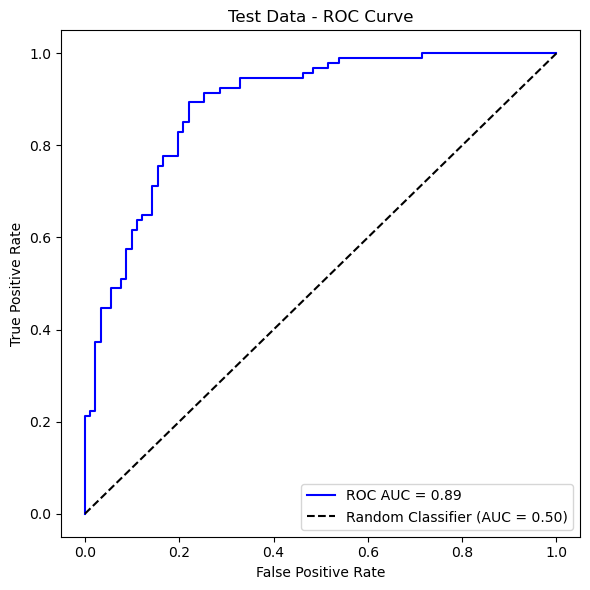

In [9]:
# Evaluate on the test dataset
y_test_pred = best_gb_model.predict(X_test)
y_test_prob = best_gb_model.predict_proba(X_test)[:, 1]

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate ROC for test dataset
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Print the values
print("Test Data ROC AUC:", roc_auc_test)
print("Test Data FPR:", fpr_test)
print("Test Data TPR:", tpr_test)
print("Test Data Thresholds:", thresholds_test)

# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))  # This defines 'ax' properly

# Plot ROC curve
ax.plot(fpr_test, tpr_test, label=f"ROC AUC = {roc_auc_test:.2f}", color="blue")
ax.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
ax.set_title("Test Data - ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("gb_esm2_roc_auc_curve.png", dpi=500)
print("ROC curve saved as 'gb_esm2_roc_auc_curve.png'.")

# Show the plot
plt.show()

In [10]:
# Perform 10-fold cross-validation on the best model
cross_val_scores = cross_val_score(best_gb_model, X_train, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cross_val_scores)
print("Mean 10-Fold CV Accuracy:", cross_val_scores.mean())

# save accuracy of each fold to a text file
with open('cv_accuracies_gb_esm2.txt', 'w') as f:
    f.write("Cross-Validation Accuracies for each fold:\n")
    for i, score in enumerate(cross_val_scores):
        f.write(f"Fold {i+1} Accuracy: {score:.4f}\n")

print("Accuracy of each fold has been saved to 'cv_accuracies_gb_esm2.txt'")

10-Fold Cross-Validation Accuracy Scores: [0.72972973 0.89189189 0.75675676 0.81081081 0.82432432 0.78378378
 0.83783784 0.74324324 0.82191781 0.87671233]
Mean 10-Fold CV Accuracy: 0.807700851536468
Accuracy of each fold has been saved to 'cv_accuracies_gb_esm2.txt'


Mean Accuracy: 80.77
Mean AUC: 1.0000


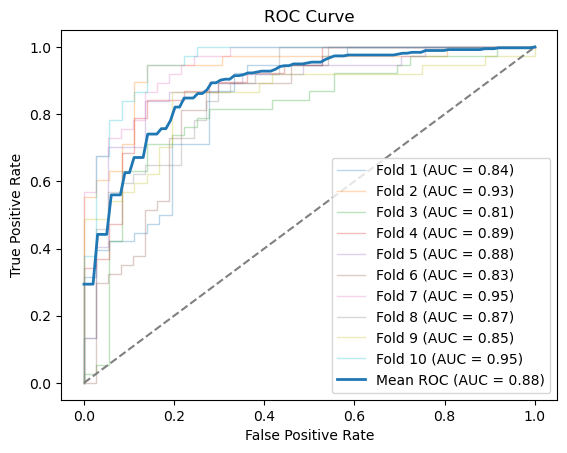

In [11]:
# make roc curve of all folds with mean auc and mean accuracy printed on the plot
mean_accuracy = cross_val_scores.mean() * 100
print(f"Mean Accuracy: {mean_accuracy:.2f}")
# Step 6: Generate ROC Curve
mean_auc = roc_auc_score(y_train, best_gb_model.predict_proba(X_train)[:, 1])
print(f"Mean AUC: {mean_auc:.4f}")

cv = StratifiedKFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    best_gb_model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    y_prob = best_gb_model.predict_proba(X_train.iloc[test_idx])[:, 1]
    fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("cv_roc_curve_gb_esm2.png", dpi=500)
plt.show()